In [39]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.feature_selection import SelectKBest, chi2
import heapq, operator

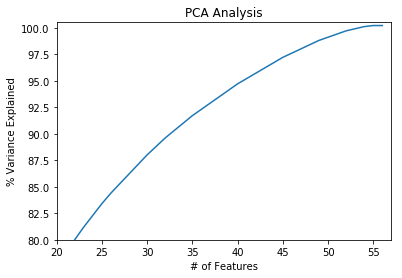

In [40]:
def read_data():
    data = pd.read_csv("dataset.txt", delimiter=',')
    features = data.iloc[:, :57].values
    target = data.iloc[:, 57:].values
    # normalize the data
    features = MinMaxScaler().fit_transform(features)
    return features, target

features, target = read_data()

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.5)

pca = PCA(n_components=57, svd_solver='full')
pca.fit(x_train)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(80,100.5)
plt.xlim(20, 57)
plt.style.context('seaborn-whitegrid')


plt.plot(var) 

# PCA Analysis
As you can see here in the PCA Analysis plot, it can be shown that proportion of variance starts to become 80% after 21 examples and variance is at 97.5-100% after 50 features. This shows that after 52~ features, adding more features will not make si difference.

In [41]:
print("Case 1")
classifier = KNeighborsClassifier(n_jobs=-1,n_neighbors=5,weights='uniform')  
classifier.fit(x_train, y_train.ravel()) 
y_pred = classifier.predict(x_test)  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

Case 1
[[1261  101]
 [ 157  781]]
             precision    recall  f1-score   support

          0       0.89      0.93      0.91      1362
          1       0.89      0.83      0.86       938

avg / total       0.89      0.89      0.89      2300



# Case 1
This case runs KNN without PCA and Feature Selection. It uses all of the normalized features and predicts with KNeighborsClassifier.
- Accuracy is 89~%
- Precision on average is 89~%
- Recall on average is 89~%

This result shows that KNN with all 57 features results as a good classifier for this dataset.

Case 2
[[1156  240]
 [ 252  652]]
             precision    recall  f1-score   support

          0       0.82      0.83      0.82      1396
          1       0.73      0.72      0.73       904

avg / total       0.79      0.79      0.79      2300

Accuracy:  0.7860869565217391


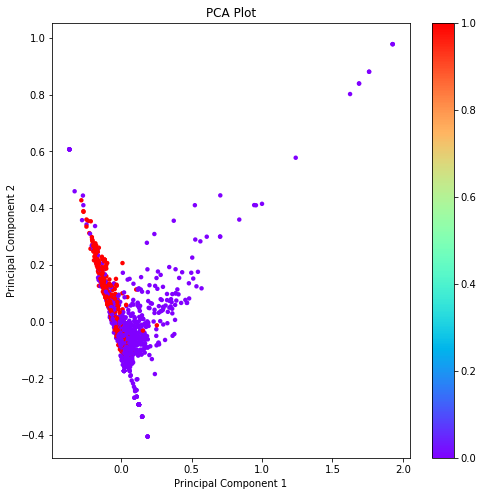

In [42]:
# Feature extraction: Use PCA to reduce dimensionality to m, followed by k-NN. Try for different values of
# m corresponding to proportion of variance of 0.80, 0.81, 0.82, ...., 0.99. Plot the data for m=2.
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.5)

def pcaknn(n_component):


    pca = PCA(n_components=n_component)
    X_train_transformed = pca.fit_transform(x_train)
    X_submission_transformed = pca.transform(x_test)

    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_train_transformed, y_train, test_size=0.5, random_state=13)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_pca[:,:n_component], y_train_pca.ravel())

    predict_labels = knn.predict(X_submission_transformed[:, :n_component])

    print(confusion_matrix(y_test, predict_labels))  
    print(classification_report(y_test, predict_labels)) 
    print("Accuracy: ", accuracy_score(y_test, predict_labels))
    
    plt.figure(figsize = (8,8))
    plt.scatter(X_train_transformed[:,0],X_train_transformed[:,1], s=20, c = y_train.ravel(), cmap = "rainbow", edgecolor = "None")
    plt.colorbar()
    plt.clim(0,1)
    plt.title("PCA Plot")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

print("Case 2")
pcaknn(2)

# Case 2

In this case, PCA function of Sci-kit has been used. By using PCA and applying necessary steps for dataset and test, x_train has transformed into a set which has sorted columns by the features' variances which is a priority in this problem. By selecting the first nth column (2 in this case), KNN has been applied.

## Result of KNN
- Accuracy is 80~%
- Precision on average is 80~%
- Recall on average is 80~%

This result shows that Principal Component Analysis did a good job finding the most important features given that 80% accuracy with only 2 Principal Components.

## Plot of n_component=2

Result divergence can be seen easily in this plot. Results for each class has been accumulated which shows PCA has done a successful job.

Case 3
Confusion Matrix: 
[[1229  181]
 [ 553  337]]
Metrics: 
             precision    recall  f1-score   support

          0       0.69      0.87      0.77      1410
          1       0.65      0.38      0.48       890

avg / total       0.67      0.68      0.66      2300

Accuracy:  0.6808695652173913


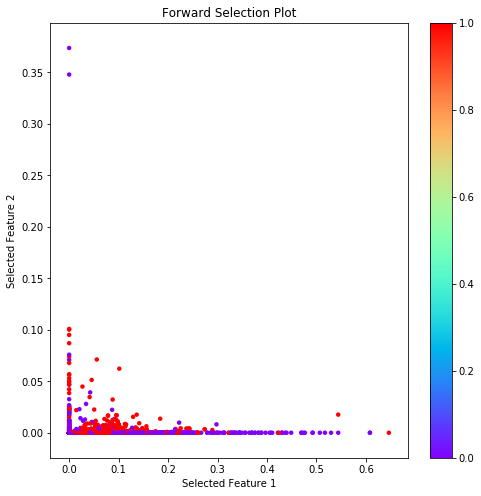

In [45]:
# Case 3
# Feature Selection: Use forward selection to reduce dimensionality to m using k-NN as predictor. Train the model for each m between 1 and 57. Also plot the data for m=2.

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.5)

def knnknn(n_component):   
    selector = SelectKBest(chi2, k=2)
    fit = selector.fit(x_train, y_train.ravel())
    np.set_printoptions(precision=3)
    scores = selector.pvalues_
    biggest_indices = sorted(range(len(scores)), key=lambda i: float(scores[i]), reverse=True)[:n_component]
    
    features = fit.transform(x_train)
    x_train_reduced_by_k = x_train[:, biggest_indices]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train_reduced_by_k[:, :], y_train.ravel())

    predict_labels = knn.predict(x_test[:, biggest_indices])
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, predict_labels))  
    print("Metrics: ")
    print(classification_report(y_test, predict_labels)) 
    print("Accuracy: ", accuracy_score(y_test, predict_labels))

    plt.figure(figsize = (8,8))
    plt.scatter(x_train_reduced_by_k[:,0],x_train_reduced_by_k[:,1], s=20, c = y_train.ravel(), cmap = "rainbow", edgecolor = "None")
    plt.colorbar()
    plt.clim(0,1)
    plt.title("Forward Selection Plot")
    plt.xlabel("Selected Feature 1")
    plt.ylabel("Selected Feature 2")

print("Case 3")
knnknn(2)

# Case 3

In this case, instead of using PCA for finding most important features, SelectKBest has been used to determine the strongest relationships of the features with the output variable. It scores the relationships of each feature and gets the nth strongest features in transform function (2 in this case). This example uses the chi squared (chi^2) statistical test for non-negative features to select 2 of the best features from the dataset given. For having non-negative features, min-max scaling has been used. After selecthing n number of strongest relation features, KNN has been applied.

## Result of KNN
- Accuracy is 66~%
- Precision on average is 65~%
- Recall on average is 66~%

This result shows that it has given a worse performance compared to PCA(or I have done something wrong). But still it is higher than pure chance (Which is 50% in binary classification). It might be useful in an appropriate application perhaps.

## Plot of n_component=2

Result divergence is not as easily can be seen compared to PCA Plot. Plot is more mixed compared to PCA Plot. But still for two features only, I believe that it has not result in a bad favor. 

# Final Comments
I have seen that when the m=2 plot results in more diversed, more divisible results for class values, all of the metric scores are better. I have also seen that Principal Component Analysis is amazing complexity-wise, especially it must have been playing a major role in very big datasets.